# Setup

## Config

In [4]:
# to mount w281FinalProjectLogo - you can go to Drive > Shared with me > Add Shortcut to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Import libraries
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from scipy.stats import moment
import math, random
import json, copy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [7]:
# Define paths
base_dir = '/content/drive/MyDrive/w281FinalProjectLogo/Logos-32plus_v1.0.1/'

image_dir         = base_dir + 'images/'
bbox_dir          = base_dir + 'yolofinalset/obj_train_data/'
preproc_dir       = base_dir + 'preprocessed/'
preproc_bb_dir    = preproc_dir + 'bb/'
preproc_cn_dir    = preproc_dir + 'cn/'
preproc_da_dir    = preproc_dir + 'da/'
preproc_gray_dir  = preproc_dir + 'gray/'

os.chdir(base_dir)

class_dirs = os.listdir(image_dir)[1:]
class_map = ['adidas', 'apple', 'bmw', 'cocacola', 'dhl', 'fedex', 'heineken', 'pepsi', 'starbucks', 'ups']
inv_class_map = { v: k for k, v in enumerate(class_map) }

## Clear output

In [484]:
# remove bb files
files = glob.glob(preproc_dir + 'bb/*')
for f in files:
  os.remove(f)

# os.remove(preproc_dir + 'class_map_summary_bb.json')
# os.remove(preproc_dir + 'preproc_map_bb.json')
os.listdir(preproc_bb_dir)

[]

In [485]:
# remove cn files
files = glob.glob(preproc_dir + 'cn/*')
for f in files:
  os.remove(f)

os.remove(preproc_dir + 'class_map_summary_cn.json')
os.remove(preproc_dir + 'preproc_map_cn.json')
os.listdir(preproc_cn_dir)

[]

In [535]:
# remove da files
files = glob.glob(preproc_dir + 'da/*')
for f in files:
  os.remove(f)

# os.remove(preproc_dir + 'class_map_summary_da.json')
# os.remove(preproc_dir + 'preproc_map_da.json')
os.listdir(preproc_da_dir)

[]

In [486]:
# remove gray files
files = glob.glob(preproc_dir + 'gray/*')
for f in files:
  os.remove(f)

# os.remove(preproc_dir + 'class_map_summary_gray.json')
# os.remove(preproc_dir + 'preproc_map_gray.json')
os.listdir(preproc_gray_dir)

[]

In [17]:
# remove img json files in preproc_dir
# os.remove(preproc_dir + 'groundtruth_dict.json')
# os.remove(preproc_dir + 'preproc_map_img.json')
# os.remove(preproc_dir + 'class_map_summary_img.json')
# os.remove(preproc_dir + 'train_test_split_img.json')
# os.remove(preproc_dir + 'img_preproc_dict_tt.json')
os.listdir(preproc_dir)

['bb',
 'cn',
 'da',
 'gray',
 'preproc_map_bb.json',
 'class_map_summary_bb.json',
 'preproc_map_img.json',
 'class_map_summary_img.json',
 'train_test_split_img.json',
 'img_preproc_dict_tt.json',
 'preproc_map_cn.json',
 'class_map_summary_cn.json',
 'preproc_map_da.json',
 'class_map_summary_da.json',
 'preproc_map_gray.json',
 'class_map_summary_gray.json']

# Train-test split

In [490]:
# train test split
class_map_summary_img = { v: {'code': k, 'num_imgs': 0} for k, v in enumerate(class_map) }
img_preproc_dict_img = {}

for class_dir in tqdm(class_dirs):
  if class_dir not in class_map:
    continue

  img_fnames = os.listdir(image_dir + class_dir)

  for img_fname in img_fnames:
    class_map_summary_img[class_dir]['num_imgs'] += 1
    img_preproc_dict_img[img_fname] = {
      'image_source': '/images/' + class_dir + '/' + img_fname,
      'preprocessing': ['tt_split'],
      'class': class_dir,
      'class_code': inv_class_map[class_dir] 
    }

print('Image counts per class:\n')
for k,v in class_map_summary_img.items():
  print(k, '     \t', v['num_imgs'])

print('\nTotal image count -', len(img_preproc_dict_img.items()))
print('Average image count per class -', len(img_preproc_dict_img.items()) / len(class_map_summary_img.items()))

  0%|          | 0/32 [00:00<?, ?it/s]

Image counts per class:

adidas      	 166
apple      	 433
bmw      	 502
cocacola      	 341
dhl      	 348
fedex      	 225
heineken      	 113
pepsi      	 281
starbucks      	 442
ups      	 217

Total image count - 3068
Average image count per class - 306.8


In [491]:
# save dictionaries to file
with open(preproc_dir + "preproc_map_img.json", "w") as outfile:
  json.dump(img_preproc_dict_img, outfile)

with open(preproc_dir + "class_map_summary_img.json", "w") as outfile:
  json.dump(class_map_summary_img, outfile)

In [36]:
# read dictionaries from file
with open(preproc_dir + "preproc_map_img.json", "r") as outfile:
  img_preproc_dict_img = json.load(outfile)

with open(preproc_dir + "class_map_summary_img.json", "r") as outfile:
  class_map_summary_img = json.load(outfile)

In [37]:
# stratified train and test split
X = np.array(list(img_preproc_dict_img.keys()))
y = np.array([elem['class_code'] for elem in img_preproc_dict_img.values()])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.50, random_state=42)

In [38]:
train_test_split_img = {
  'X_train': list(X_train),
  'y_train': y_train.tolist(),
  'X_val': list(X_val),
  'y_val': y_val.tolist(), 
  'X_test': list(X_test),
  'y_test': y_test.tolist()
}

print('Total image count per data split:\n')
print('train\t', len(train_test_split_img['X_train']))
print('val\t', len(train_test_split_img['X_val']))
print('test\t', len(train_test_split_img['X_test']))

Total image count per data split:

train	 2147
val	 461
test	 460


In [495]:
# save dictionary to file
with open(preproc_dir + "train_test_split_img.json", "w") as outfile:
  json.dump(train_test_split_img, outfile)

In [496]:
# read dictionary from file
with open(preproc_dir + "train_test_split_img.json", "r") as outfile:
  train_test_split_img = json.load(outfile)

In [497]:
# create img lookup dictionary and class summary dictionary
img_preproc_dict_tt = {}
class_map_summary_tt = { v: {'code': k, 'train': 0, 'val': 0, 'test': 0, 'total': 0} for k,v in enumerate(class_map) }

for i in range(len(train_test_split_img['X_train'])):
  img_fname = train_test_split_img['X_train'][i]
  img_class_code = train_test_split_img['y_train'][i]
  img_class = class_map[img_class_code]

  img_preproc_dict_tt[img_fname] = {
    'class': img_class,
    'class_code': img_class_code,
    'set': 'train'
  }
  class_map_summary_tt[img_class]['train'] += 1
  class_map_summary_tt[img_class]['total'] += 1

for i in range(len(train_test_split_img['X_val'])):
  img_fname = train_test_split_img['X_val'][i]
  img_class_code = train_test_split_img['y_val'][i]
  img_class = class_map[img_class_code]

  img_preproc_dict_tt[img_fname] = {
    'class': img_class,
    'class_code': img_class_code,
    'set': 'val'
  }
  class_map_summary_tt[img_class]['val'] += 1
  class_map_summary_tt[img_class]['total'] += 1

for i in range(len(train_test_split_img['X_test'])):
  img_fname = train_test_split_img['X_test'][i]
  img_class_code = train_test_split_img['y_test'][i]
  img_class = class_map[img_class_code]

  img_preproc_dict_tt[img_fname] = {
    'class': img_class,
    'class_code': img_class_code,
    'set': 'test'
  }
  class_map_summary_tt[img_class]['test'] += 1
  class_map_summary_tt[img_class]['total'] += 1

print('Image counts per data split per class:\n')
for k,v in class_map_summary_tt.items():
  print(k, '     \t', v)

print('\nTotal image counts per data split:\n')
print('train\t', len(y_train))
print('val\t', len(y_val))
print('test\t', len(y_test))

Image counts per data split per class:

adidas      	 {'code': 0, 'train': 116, 'val': 25, 'test': 25, 'total': 166}
apple      	 {'code': 1, 'train': 303, 'val': 65, 'test': 65, 'total': 433}
bmw      	 {'code': 2, 'train': 351, 'val': 76, 'test': 75, 'total': 502}
cocacola      	 {'code': 3, 'train': 239, 'val': 51, 'test': 51, 'total': 341}
dhl      	 {'code': 4, 'train': 244, 'val': 52, 'test': 52, 'total': 348}
fedex      	 {'code': 5, 'train': 157, 'val': 34, 'test': 34, 'total': 225}
heineken      	 {'code': 6, 'train': 79, 'val': 17, 'test': 17, 'total': 113}
pepsi      	 {'code': 7, 'train': 197, 'val': 42, 'test': 42, 'total': 281}
starbucks      	 {'code': 8, 'train': 309, 'val': 67, 'test': 66, 'total': 442}
ups      	 {'code': 9, 'train': 152, 'val': 32, 'test': 33, 'total': 217}

Total image counts per data split:

train	 2147
val	 461
test	 460


In [498]:
# save dictionary to file
with open(preproc_dir + "img_preproc_dict_tt.json", "w") as outfile:
  json.dump(img_preproc_dict_tt, outfile)

In [10]:
# read dictionary from file
with open(preproc_dir + "img_preproc_dict_tt.json", "r") as outfile:
  img_preproc_dict_tt = json.load(outfile)

# Read ground truth

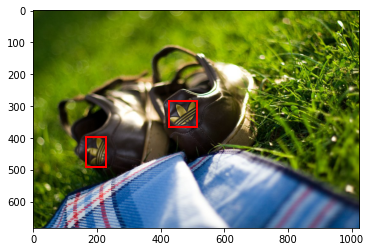


 {'class': 'adidas', 'class_code': 0, 'set': 'train', 'bboxes': [[427, 284, 87, 81], [167, 395.99999999999994, 61, 97.00000000000006]]}


In [22]:
# convert ground truth into dict indexed by file name
groundtruth_dict = copy.deepcopy(img_preproc_dict_tt)

with open(base_dir + "groundtruth.json") as f:
  groundtruth_raw = json.load(f)

for groundtruth in groundtruth_raw:
  img_fname = groundtruth['file'].split('\\')[1]
  if img_fname not in img_preproc_dict_tt:
    continue

  if type(groundtruth['bboxes'][0]) == list:
    bboxes = groundtruth['bboxes']
  else:
    bboxes = [groundtruth['bboxes']]
  groundtruth_dict[img_fname]['bboxes'] = bboxes

test_img = plt.imread(image_dir + 'adidas/000001.jpg')
for bbox in groundtruth_dict['000001.jpg']['bboxes']:
  x_top_left, y_top_left, width, height = bbox
  plt.gca().add_patch(Rectangle((x_top_left, y_top_left), width, height, linewidth=2, edgecolor='r', facecolor='none'))

plt.imshow(test_img)
plt.show()
print('\n', groundtruth_dict['000001.jpg'])

In [20]:
# save dictionary to file
with open(preproc_dir + "groundtruth_dict.json", "w") as outfile:
  json.dump(groundtruth_dict, outfile)

In [21]:
# read dictionary from file
with open(preproc_dir + "groundtruth_dict.json", "r") as outfile:
  groundtruth_dict = json.load(outfile)

## Create YOLO annotations

In [35]:
# remove yolo annotation files
groundtruth_to_yolo_dir = base_dir + 'groundtruth_to_yolo/'
files = glob.glob(groundtruth_to_yolo_dir + '*')
for f in files:
  os.remove(f)

os.listdir(groundtruth_to_yolo_dir)

[]

In [39]:
# create and save yolo annotation files for train and val images
for img_fname, img_data in tqdm(groundtruth_dict.items()):
  if img_data['set'] == 'test':
    continue
  
  yolo_data = []
  yolo_fname = img_fname.replace('jpg', 'txt')

  for bbox in img_data['bboxes']:
    img = plt.imread(image_dir + '/' + img_data['class'] + '/' + img_fname)
    img_height, img_width, _ = img.shape

    x_top_left, y_top_left, bbox_width, bbox_height = bbox
    center_x = (x_top_left + 0.5*bbox_width) / img_width
    center_y = (y_top_left + 0.5*bbox_height) / img_height
    width = bbox_width / img_width
    height = bbox_height / img_height
    yolo_data.append(f"{inv_class_map[img_data['class']]} {center_x} {center_y} {width} {height}")

  with open(groundtruth_to_yolo_dir + yolo_fname, "w") as f:
    f.write('\n'.join(yolo_data))

print('File count:', len(os.listdir(groundtruth_to_yolo_dir)))
print('Size of train + val:', len(y_train) + len(y_val))

  0%|          | 0/3068 [00:00<?, ?it/s]

File count: 2608
Size of train + val: 2608


In [44]:
# write all files to google storage bucket
!gsutil -mq cp -r /content/drive/MyDrive/w281FinalProjectLogo/Logos-32plus_v1.0.1/groundtruth_to_yolo/* gs://w281finalprojectlogo/Logos-32plus_v1.0.1/groundtruth_to_yolo

num_files = !gsutil ls gs://w281finalprojectlogo/Logos-32plus_v1.0.1/groundtruth_to_yolo
print(len(num_files))

2609


# Image processing

## Image processing functions

In [500]:
# YOLO format is [center_x, center_y, width, height]
def extract_bbox_yolo(img, center_x, center_y, width, height, gray=True):
  if gray:
    img_y, img_x = img.shape
  else:
    img_y, img_x, img_z = img.shape
  min_x = round((center_x - 0.5*width) * img_x)
  max_x = round((center_x + 0.5*width) * img_x)
  min_y = round((center_y - 0.5*height) * img_y)
  max_y = round((center_y + 0.5*height) * img_y)
  
  if gray:
    return img[min_y:max_y, min_x:max_x]
  else:
    return img[min_y:max_y, min_x:max_x,:]

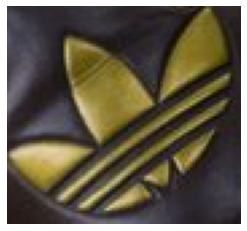

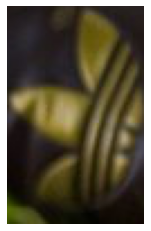

In [501]:
# groundtruth.json has format [top_left_corner_x, top_left_corner_y, width, height]
def extract_bbox_groundtruth(img, min_x, min_y, width, height, gray=False):
  max_x = min_x + width
  max_y = min_y + height
  
  if gray:
    return img[min_y:max_y, min_x:max_x]
  else:
    return img[min_y:max_y, min_x:max_x,:]

min_x, min_y, width, height = [round(x) for x in groundtruth_dict['000001.jpg']['bboxes'][0]]
test_bbox = extract_bbox_groundtruth(test_img, min_x, min_y, width, height, False)
plt.axis('off')
plt.imshow(test_bbox)
plt.show()

min_x, min_y, width, height = [round(x) for x in groundtruth_dict['000001.jpg']['bboxes'][1]]
test_bbox = extract_bbox_groundtruth(test_img, min_x, min_y, width, height, False)
plt.axis('off')
plt.imshow(test_bbox)
plt.show()

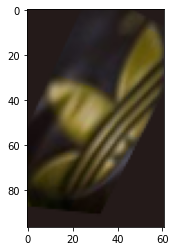

In [502]:
# Transform image by applying homography
def rotate_3d(img, x=0.0, y=0.0, z=0.0):
  # 2d to 3d (projection)
  proj2dto3d = np.array([[1,0,-img.shape[1]/2],
                         [0,1,-img.shape[0]/2],
                         [0,0,0],
                         [0,0,1]], np.float32)

  proj3dto2d = np.array([[200,0,img.shape[1]/2,0],
                         [0,200,img.shape[0]/2,0],
                         [0,0,1,0]], np.float32)
  
  # Define rotation
  ax = float(x * (math.pi / 180.0))
  ay = float(y * (math.pi / 180.0)) 
  az = float(z * (math.pi / 180.0))
  rx = np.array([[1,0,0,0],
                 [0,math.cos(ax),-math.sin(ax),0],
                 [0,math.sin(ax),math.cos(ax),0],
                 [0,0,0,1]], np.float32)
  ry = np.array([[math.cos(ay),0,-math.sin(ay),0],
                 [0,1,0,0],
                 [math.sin(ay),0,math.cos(ay),0],
                 [0,0,0,1]], np.float32)
  rz = np.array([[math.cos(az),-math.sin(az),0,0],
                 [math.sin(az),math.cos(az),0,0],
                 [0,0,1,0],
                 [0,0,0,1]], np.float32)
  r = rx.dot(ry).dot(rz)
  trans = np.array([[1,0,0,0],
                   [0,1,0,0],
                   [0,0,1,200], # 400 to move the image back in z axis so full logo shown after y-rotation
                   [0,0,0,1]], np.float32)
  
  # Execute rotation
  final = proj3dto2d.dot(trans.dot(r.dot(proj2dto3d)))   

  bvalue=(int(img[0,0,0]), int(img[0,0,1]), int(img[0,0,2]))
  dst = cv2.warpPerspective(img, final, (img.shape[1],img.shape[0]), None,
                            cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, bvalue)
  return dst

test_bbox_rot = rotate_3d(test_bbox, 30, 30, 30)
plt.imshow(test_bbox_rot)
plt.show()

In [503]:
def resize_image(img, percent):
  percent = 60 # percent of original size
  width = int(img.shape[1] * percent / 100)
  height = int(img.shape[0] * percent / 100)
  dim = (width, height)
  
  # resize image
  resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
  return resized

In [504]:
def invert_image(img):
  inv_img = cv2.bitwise_not(img)
  return(inv_img)

In [505]:
def histogram_equalize(img):
  ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
  channels = cv2.split(ycrcb)
  cv2.equalizeHist(channels[0], channels[0])
  cv2.merge(channels, ycrcb)
  cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
  return img

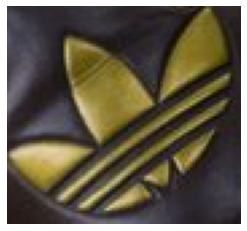

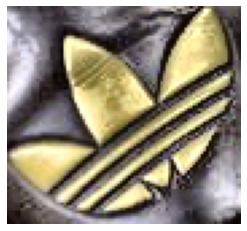

In [506]:
def clahe(img):
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  clahe = cv2.createCLAHE(tileGridSize=(4,4))
  lab[...,0] = clahe.apply(lab[...,0])
  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return bgr


center_x, center_y, width, height = [round(x) for x in groundtruth_dict['000001.jpg']['bboxes'][0]]
test_bbox = extract_bbox_groundtruth(test_img, center_x, center_y, width, height, False)
plt.axis('off')
plt.imshow(test_bbox)
plt.show()

clahe_test_img = clahe(test_bbox)
plt.axis('off')
plt.imshow(clahe_test_img)
plt.show()

In [507]:
def normalize_img(img):
  normalized = (img - img.min()) / (img.max() - img.min())
  return normalized

## Extract bounding boxes

In [508]:
# loop through original images, extract bbox using groundtruth annotations, save in color
class_map_summary_bb = { v: {'code': k, 'train': 0, 'val': 0, 'test': 0, 'total': 0} for k,v in enumerate(class_map) }
img_preproc_dict_bb = {}

for c_dir in tqdm(class_dirs):
  if c_dir not in class_map:
    continue
  
  img_fnames = os.listdir(image_dir + '/' + c_dir)

  for img_fname in img_fnames:
    img_data = groundtruth_dict.get(img_fname)

    if img_data:
      img_bgr = plt.imread(image_dir + '/' + c_dir + '/' + img_fname)
      img_class = img_data['class']
      img_set = img_preproc_dict_tt[img_fname]['set']

      for num, line in enumerate(img_data['bboxes']):
        min_x, min_y, width, height = [round(x) for x in line]
        bbox_img_bgr_color = extract_bbox_groundtruth(img_bgr, min_x, min_y, width, height, False)
        
        new_img_fname = img_fname.split('.')[0] + '_' + str(num).zfill(2) + '_bb.jpg'
        plt.imsave(preproc_bb_dir + new_img_fname, bbox_img_bgr_color)

        class_map_summary_bb[img_class]['total'] += 1
        class_map_summary_bb[img_class][img_set] += 1
        img_preproc_dict_bb[new_img_fname] = {
          'image_source': '/images/' + c_dir + '/' + img_fname,
          'preprocessing': ['bbox'],
          'class': img_class,
          'class_code': inv_class_map[img_class],
          'set': img_set,
        }

print('Image counts per data split per class:\n')
for k,v in class_map_summary_bb.items():
  print(k, '     \t', v)

print('\nTotal image count -', len(img_preproc_dict_bb.items()))
print('Total stored image count -', len(os.listdir(preproc_bb_dir)))

  0%|          | 0/32 [00:00<?, ?it/s]

Image counts per data split per class:

adidas      	 {'code': 0, 'train': 147, 'val': 33, 'test': 28, 'total': 208}
apple      	 {'code': 1, 'train': 378, 'val': 70, 'test': 82, 'total': 530}
bmw      	 {'code': 2, 'train': 403, 'val': 81, 'test': 81, 'total': 565}
cocacola      	 {'code': 3, 'train': 364, 'val': 78, 'test': 71, 'total': 513}
dhl      	 {'code': 4, 'train': 474, 'val': 92, 'test': 88, 'total': 654}
fedex      	 {'code': 5, 'train': 364, 'val': 74, 'test': 81, 'total': 519}
heineken      	 {'code': 6, 'train': 150, 'val': 62, 'test': 31, 'total': 243}
pepsi      	 {'code': 7, 'train': 361, 'val': 53, 'test': 100, 'total': 514}
starbucks      	 {'code': 8, 'train': 376, 'val': 81, 'test': 79, 'total': 536}
ups      	 {'code': 9, 'train': 230, 'val': 50, 'test': 36, 'total': 316}

Total image count - 4598
Total stored image count - 4598


In [509]:
# save dictionaries to file
with open(preproc_dir + "preproc_map_bb.json", "w") as outfile:
  json.dump(img_preproc_dict_bb, outfile)

with open(preproc_dir + "class_map_summary_bb.json", "w") as outfile:
  json.dump(class_map_summary_bb, outfile)

In [510]:
# load dictionaries
with open(preproc_dir + "preproc_map_bb.json", "r") as outfile:
  img_preproc_dict_bb = json.load(outfile)

with open(preproc_dir + "class_map_summary_bb.json", "r") as outfile:
  class_map_summary_bb = json.load(outfile)

## Contrast normalization

In [511]:
# image contrast normalization using CLAHE
img_preproc_dict_cn = {}
class_map_summary_cn = { v: {'code': k, 'train': 0, 'val': 0, 'test': 0, 'total': 0} for k,v in enumerate(class_map) }

for img_fname, img_data in tqdm(img_preproc_dict_bb.items()):
  img = plt.imread(preproc_bb_dir + img_fname)
  img_cn = normalize_img(clahe(img.copy()))
  img_class = img_class
  img_set = img_data['set']

  new_img_fname = img_fname.split('.')[0] + '_cn.jpg'
  plt.imsave(preproc_cn_dir + new_img_fname, img_cn)
  
  class_map_summary_cn[img_class]['total'] += 1
  class_map_summary_cn[img_class][img_set] += 1
  img_preproc_dict_cn[new_img_fname] = {
    'image_source': img_data['image_source'],
    'preprocessing': ['bbox','cn'],
    'class': img_class,
    'class_code': img_data['class_code'],
    'set' : img_set
  }

print('Image counts per data split per class:\n')
for k,v in class_map_summary_cn.items():
  print(k, '     \t', v)

print('\nTotal image count -', len(img_preproc_dict_cn.items()))
print('Total stored image count -', len(os.listdir(preproc_cn_dir)))

  0%|          | 0/4598 [00:00<?, ?it/s]

Image counts per data split per class:

adidas      	 {'code': 0, 'train': 147, 'val': 33, 'test': 28, 'total': 208}
apple      	 {'code': 1, 'train': 378, 'val': 70, 'test': 82, 'total': 530}
bmw      	 {'code': 2, 'train': 403, 'val': 81, 'test': 81, 'total': 565}
cocacola      	 {'code': 3, 'train': 364, 'val': 78, 'test': 71, 'total': 513}
dhl      	 {'code': 4, 'train': 474, 'val': 92, 'test': 88, 'total': 654}
fedex      	 {'code': 5, 'train': 364, 'val': 74, 'test': 81, 'total': 519}
heineken      	 {'code': 6, 'train': 150, 'val': 62, 'test': 31, 'total': 243}
pepsi      	 {'code': 7, 'train': 361, 'val': 53, 'test': 100, 'total': 514}
starbucks      	 {'code': 8, 'train': 376, 'val': 81, 'test': 79, 'total': 536}
ups      	 {'code': 9, 'train': 230, 'val': 50, 'test': 36, 'total': 316}

Total image count - 4598
Total stored image count - 4598


In [512]:
# save dictionaries to file
with open(preproc_dir + "preproc_map_cn.json", "w") as outfile:
  json.dump(img_preproc_dict_cn, outfile)

with open(preproc_dir + "class_map_summary_cn.json", "w") as outfile:
  json.dump(class_map_summary_cn, outfile)

In [513]:
# load dictionaries
with open(preproc_dir + "preproc_map_cn.json", "r") as outfile:
  img_preproc_dict_cn = json.load(outfile)

with open(preproc_dir + "class_map_summary_cn.json", "r") as outfile:
  class_map_summary_cn = json.load(outfile)

## Data augmentation

In [534]:
# calculate number of augmented images per class
max_da_count = 2000
da_aug_class_counts = {}

for img_class in class_map:
  aug_count = math.floor(max_da_count / class_map_summary_cn[img_class]['train'])
  da_aug_class_counts[img_class] = {'aug_count': aug_count, 'target_total': (aug_count + 1) * class_map_summary_cn[img_class]['train']}

print('Generated image count per source image per class:\n')
for k,v in class_map_summary_cn.items():
  print(k, '     \t', v)
  print('\t\t', da_aug_class_counts[k], '\n')

Generated image count per source image per class:

adidas      	 {'code': 0, 'train': 147, 'val': 33, 'test': 28, 'total': 208}
		 {'aug_count': 13, 'target_total': 2058} 

apple      	 {'code': 1, 'train': 378, 'val': 70, 'test': 82, 'total': 530}
		 {'aug_count': 5, 'target_total': 2268} 

bmw      	 {'code': 2, 'train': 403, 'val': 81, 'test': 81, 'total': 565}
		 {'aug_count': 4, 'target_total': 2015} 

cocacola      	 {'code': 3, 'train': 364, 'val': 78, 'test': 71, 'total': 513}
		 {'aug_count': 5, 'target_total': 2184} 

dhl      	 {'code': 4, 'train': 474, 'val': 92, 'test': 88, 'total': 654}
		 {'aug_count': 4, 'target_total': 2370} 

fedex      	 {'code': 5, 'train': 364, 'val': 74, 'test': 81, 'total': 519}
		 {'aug_count': 5, 'target_total': 2184} 

heineken      	 {'code': 6, 'train': 150, 'val': 62, 'test': 31, 'total': 243}
		 {'aug_count': 13, 'target_total': 2100} 

pepsi      	 {'code': 7, 'train': 361, 'val': 53, 'test': 100, 'total': 514}
		 {'aug_count': 5, 'target

In [537]:
# data augmentation on train examples
img_preproc_dict_da = {}
class_map_summary_da = { v: {'code': k, 'train': 0, 'val': 0, 'test': 0, 'total': 0} for k,v in enumerate(class_map) }

for img_fname, img_data in tqdm(img_preproc_dict_cn.items()):
  img_class = img_data['class']
  img_set = img_data['set']
  if img_set != 'train':
    class_map_summary_da[img_class]['total'] += 1
    class_map_summary_da[img_class][img_set] += 1
    continue

  img_da = plt.imread(preproc_cn_dir + img_fname)
  aug_count = da_aug_class_counts[img_class]['aug_count']

  xrots = [0] + random.sample(range(-30, 30, 1), aug_count)
  yrots = [0] + random.sample(range(-30, 30, 1), aug_count)
  zrots = [0] + random.sample(range(-45, 45, 1), aug_count)
  invs = [0] + [random.randint(0,1) for x in range(aug_count)]

  for num,(xrot,yrot,zrot,inv) in enumerate(zip(xrots,yrots,zrots,invs)): 
    rdm_img = rotate_3d(img_da, x=xrot, y=yrot, z=zrot)
    if inv:
      rdm_img = invert_image(rdm_img)

    new_img_fname = img_fname.split('.')[0] + '_' + str(num).zfill(2) + '_da.jpg'
    plt.imsave(preproc_da_dir + new_img_fname, rdm_img)

    class_map_summary_da[img_class]['total'] += 1
    class_map_summary_da[img_class][img_set] += 1
    img_preproc_dict_da[new_img_fname] = {
      'image_source': img_data['image_source'],
      'preprocessing': ['bbox','cn','da'],
      'class': img_class,
      'class_code': img_data['class_code'],
      'set' : img_set
    }

print('Image counts per data split per class:\n')
for k,v in class_map_summary_da.items():
  print(k, '     \t', v)

print('\nTotal image count -', len(img_preproc_dict_da.items()))
print('Total stored image count -', len(os.listdir(preproc_da_dir)))

  0%|          | 0/4598 [00:00<?, ?it/s]

Image counts per data split per class:

adidas      	 {'code': 0, 'train': 2058, 'val': 33, 'test': 28, 'total': 2119}
apple      	 {'code': 1, 'train': 2268, 'val': 70, 'test': 82, 'total': 2420}
bmw      	 {'code': 2, 'train': 2015, 'val': 81, 'test': 81, 'total': 2177}
cocacola      	 {'code': 3, 'train': 2184, 'val': 78, 'test': 71, 'total': 2333}
dhl      	 {'code': 4, 'train': 2370, 'val': 92, 'test': 88, 'total': 2550}
fedex      	 {'code': 5, 'train': 2184, 'val': 74, 'test': 81, 'total': 2339}
heineken      	 {'code': 6, 'train': 2100, 'val': 62, 'test': 31, 'total': 2193}
pepsi      	 {'code': 7, 'train': 2166, 'val': 53, 'test': 100, 'total': 2319}
starbucks      	 {'code': 8, 'train': 2256, 'val': 81, 'test': 79, 'total': 2416}
ups      	 {'code': 9, 'train': 2070, 'val': 50, 'test': 36, 'total': 2156}

Total image count - 21671
Total stored image count - 21671


In [538]:
# save dictionaries to file
with open(preproc_dir + "preproc_map_da.json", "w") as outfile:
  json.dump(img_preproc_dict_da, outfile)

with open(preproc_dir + "class_map_summary_da.json", "w") as outfile:
  json.dump(class_map_summary_da, outfile)

In [539]:
# load dictionaries
with open(preproc_dir + "preproc_map_da.json", "r") as outfile:
  img_preproc_dict_da = json.load(outfile)

with open(preproc_dir + "class_map_summary_da.json", "r") as outfile:
  class_map_summary_da = json.load(outfile)

## Grayscale images

In [540]:
# save grayscale version of final image set
img_preproc_dict_gray = {}
class_map_summary_gray = { v: {'code': k, 'train': 0, 'val': 0, 'test': 0, 'total': 0} for k,v in enumerate(class_map) }

for img_fname, img_data in tqdm(img_preproc_dict_da.items()):
  img_gray_in = plt.imread(preproc_da_dir + img_fname)
  img_gray = cv2.cvtColor(img_gray_in, cv2.COLOR_BGR2GRAY)
  img_class = img_data['class']
  img_set = img_data['set']

  new_img_fname = img_fname.split('.')[0] + '_gray.jpg'
  plt.imsave(preproc_gray_dir + new_img_fname, img_gray, cmap='gray')
  
  class_map_summary_gray[img_class]['total'] += 1
  class_map_summary_gray[img_class][img_set] += 1
  img_preproc_dict_gray[new_img_fname] = {
    'image_source': img_data['image_source'],
    'preprocessing': ['bbox','cn','da','gray'],
    'class': img_class,
    'class_code': img_data['class_code'],
    'set': img_set
  }

print('Image counts per data split per class:\n')
for k,v in class_map_summary_gray.items():
  print(k, '     \t', v)

print('\nTotal image count -', len(img_preproc_dict_gray.items()))
print('Total stored image count -', len(os.listdir(preproc_gray_dir)))

  0%|          | 0/21671 [00:00<?, ?it/s]

Image counts per data split per class:

adidas      	 {'code': 0, 'train': 2058, 'val': 0, 'test': 0, 'total': 2058}
apple      	 {'code': 1, 'train': 2268, 'val': 0, 'test': 0, 'total': 2268}
bmw      	 {'code': 2, 'train': 2015, 'val': 0, 'test': 0, 'total': 2015}
cocacola      	 {'code': 3, 'train': 2184, 'val': 0, 'test': 0, 'total': 2184}
dhl      	 {'code': 4, 'train': 2370, 'val': 0, 'test': 0, 'total': 2370}
fedex      	 {'code': 5, 'train': 2184, 'val': 0, 'test': 0, 'total': 2184}
heineken      	 {'code': 6, 'train': 2100, 'val': 0, 'test': 0, 'total': 2100}
pepsi      	 {'code': 7, 'train': 2166, 'val': 0, 'test': 0, 'total': 2166}
starbucks      	 {'code': 8, 'train': 2256, 'val': 0, 'test': 0, 'total': 2256}
ups      	 {'code': 9, 'train': 2070, 'val': 0, 'test': 0, 'total': 2070}

Total image count - 21671
Total stored image count - 21671


In [541]:
# save dictionaries to file
with open(preproc_dir + "preproc_map_gray.json", "w") as outfile:
  json.dump(img_preproc_dict_gray, outfile)

with open(preproc_dir + "class_map_summary_gray.json", "w") as outfile:
  json.dump(class_map_summary_gray, outfile)

## Upload to cloud storage

In [542]:
from google.colab import auth
auth.authenticate_user()

# display files and directories from bucket
!gsutil ls gs://w281finalprojectlogo/Logos-32plus_v1.0.1/

gs://w281finalprojectlogo/Logos-32plus_v1.0.1/.DS_Store
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/groundtruth.mat
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/hu_moments_train.json
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/hu_moments_train.npy
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/hu_moments_val.npy
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/image.png
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/feature_extraction/
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/images/
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/preprocessed/
gs://w281finalprojectlogo/Logos-32plus_v1.0.1/yolofinalset/


In [ ]:
# write all of preprocessed/ to google storage bucket
!gsutil -mq cp -r /content/drive/MyDrive/w281FinalProjectLogo/Logos-32plus_v1.0.1/preprocessed/* gs://w281finalprojectlogo/Logos-32plus_v1.0.1/preprocessedv2/

In [42]:
num_gray_imgs = !gsutil ls gs://w281finalprojectlogo/Logos-32plus_v1.0.1/preprocessedv2/gray
print(len(num_gray_imgs))

21671
